In [2]:
import models
import utils
import torch
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
from permutation_metrics import rank_similarities, rank_similarities_real

%load_ext autoreload
%autoreload 2

torch.manual_seed(42)
np.random.seed(42)

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

guess_prob = 1/5

## Dataset: Sigmoid Uncorrel

In [3]:
R = torch.tensor(np.load('../datasets/sigmoid_irf_uncorrel.npy'), dtype=dtype)
A_true = np.load('../datasets/students_uncorrel.npy')
D_true = np.load('../datasets/questions_uncorrel.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]

In [9]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob, 10)
max_acc, best_params = utils.hyperparam_search(models.FE_Model, init_params, {'lr':(-3,-1), 'reg':(-3,-1), 'momentum':(-1, 0)}, 10, 300, R)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.005336533066379609, reg=0.08781408196485974, momentum=0.9171646234807422


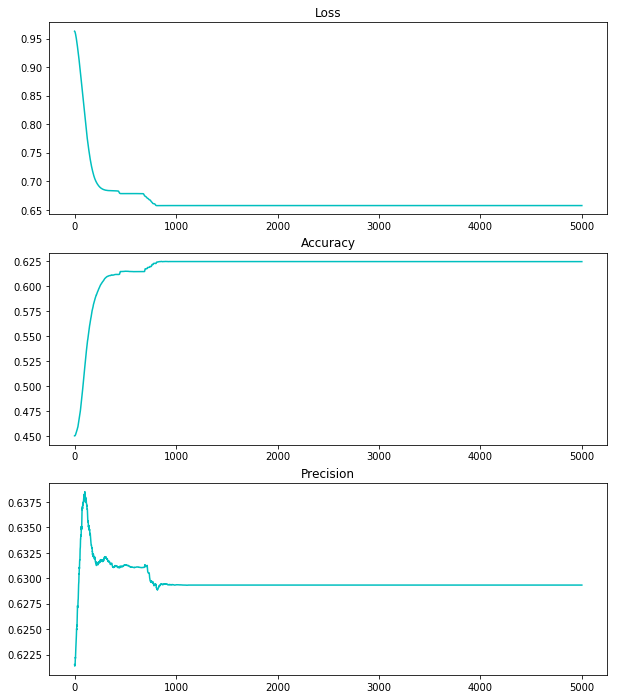

In [12]:
l, r, m = best_params
fe_irf = models.FE_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(fe_irf.parameters(), lr=l, weight_decay=r, momentum=m)
losses, train_acc, precision = utils.train(fe_irf, optim, 2000, R)
utils.plot_train_metrics(losses, train_acc, precision)

Here we calculate the RMSE between the inferred A and D matrices and their actual counterparts.

In [14]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(utils.min_max_normalize(fe_irf.A), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(utils.min_max_normalize(fe_irf.D), torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.17409883439540863
RMSE(D, D_true) =  0.09180466085672379


We now compare the student ranking produced by the inferred abilities matrix to the actual ranking, and to the baseline ranking produced by the students' raw scores.

In [15]:
results = rank_similarities(A_true, R.detach().numpy(), fe_irf.A.detach().numpy())
print(results['summary'])


    Summary of Ranking Evaluation: 
    Correlations with true rankings derived from A_true.
        Baseline: 
            Kendall:0.434 (p-value 0.0)
            Spearman: 0.608 (p-value 0.0) 
            
        Prediction:
            Kendall: 0.429 (p-value 0.0)
            Spearman: 0.607 (p-value 0.0)  
            
    Average difference: -0.003 (absolute diff., vs. the baseline) 
    


For the sake of some exploration we compare the inferred model's accuracy with the accuracy of the model using the actual A and D matrices used to simulate the dataset in the first place (this is called oracle accuracy). We also look at the scores distribution generated by the actual A and D matrices. As it turns out this distribution says a lot about the general behavior of the model, and explains why the (actual) floored exponential model attains higher accuracy on its own dataset than the does the (actual) sigmoid model on its dataset.

In [17]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.two_param_sigmoid_irf(_A[:, concepts[1]], _D[concepts], guess_prob)
preds = (scores >= 0.5).float()
print('Oracle accuracy: ', torch.sum(R == preds).item() / (R.shape[0] * R.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Oracle accuracy:  0.61892
Inferred model accuracy:  0.6242899894714355
Inferred model precision:  0.629334568977356


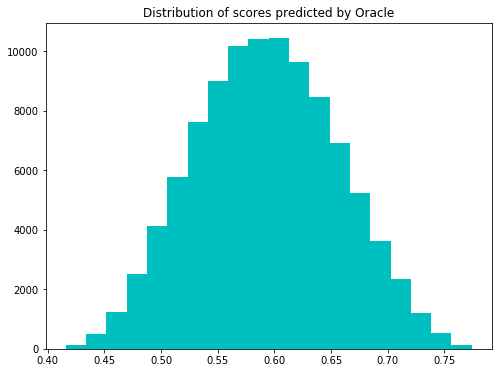

In [18]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by Oracle')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Dataset: Sigmoid Correl

In [25]:
R = torch.tensor(np.load('../datasets/sigmoid_irf_correl.npy'), dtype=dtype)
A_true = np.load('../datasets/students_correl.npy')
D_true = np.load('../datasets/questions_correl.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]

In [26]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob, 10)
max_acc, best_params = utils.hyperparam_search(models.FE_Model, init_params, {'lr':(-3,-1), 'reg':(-3,-1), 'momentum':(-1, 0)}, 10, 300, R)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.018830411164464725, reg=0.028325831505321846, momentum=0.945914928223288


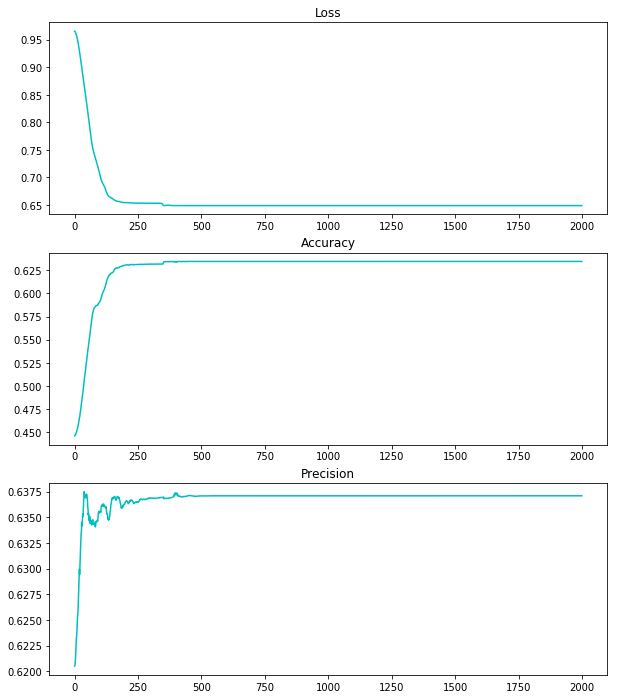

In [27]:
l, r, m = best_params
fe_irf = models.FE_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(fe_irf.parameters(), lr=l, weight_decay=r, momentum=m)
losses, train_acc, precision = utils.train(fe_irf, optim, 2000, R)
utils.plot_train_metrics(losses, train_acc, precision)

In [28]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(utils.min_max_normalize(fe_irf.A), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(utils.min_max_normalize(fe_irf.D), torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.2533019185066223
RMSE(D, D_true) =  0.8904412984848022


In [29]:
from collections import Counter
counts = Counter(concepts[1])
total = len(concepts[1])
weights = {k: v/total for k, v in counts.items()}
weights

{4: 0.15, 2: 0.17, 0: 0.2, 1: 0.28, 3: 0.2}

In [31]:
weights = np.array([0.2, 0.28, 0.17, 0.2, 0.15])
results = rank_similarities(A_true, R.detach().numpy(), fe_irf.A.detach().numpy(), skill_weights=weights)
print(results['summary'])


    Summary of Ranking Evaluation: 
    Correlations with true rankings derived from A_true.
        Baseline: 
            Kendall:0.274 (p-value 0.0)
            Spearman: 0.397 (p-value 0.0) 
            
        Prediction:
            Kendall: 0.277 (p-value 0.0)
            Spearman: 0.408 (p-value 0.0)  
            
    Average difference: 0.007 (absolute diff., vs. the baseline) 
    


In [32]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.two_param_sigmoid_irf(_A[:, concepts[1]], _D[concepts], guess_prob)
preds = (scores >= 0.5).float()
print('Oracle accuracy: ', torch.sum(R == preds).item() / (R.shape[0] * R.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Oracle accuracy:  0.62162
Inferred model accuracy:  0.6345000267028809
Inferred model precision:  0.6371004581451416


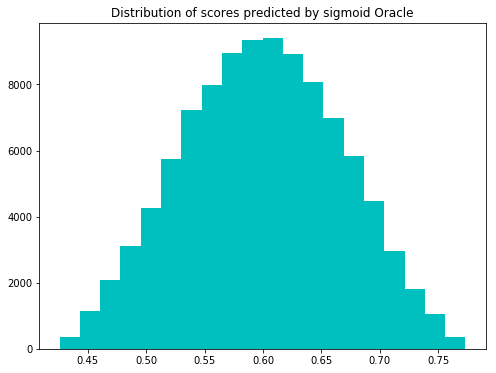

In [33]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by Oracle')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Dataset: FE Uncorrel

In [35]:
R = torch.tensor(np.load('../datasets/floored_exp_uncorrel.npy'), dtype=dtype)
A_true = np.load('../datasets/students_uncorrel.npy')
D_true = np.load('../datasets/questions_uncorrel.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]

In [36]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob, 10)
max_acc, best_params = utils.hyperparam_search(models.FE_Model, init_params, {'lr':(-6,-1), 'reg':(-5,-1)}, 10, 300, R)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.08964492537002863, reg=0.00044716799012313056, momentum=0


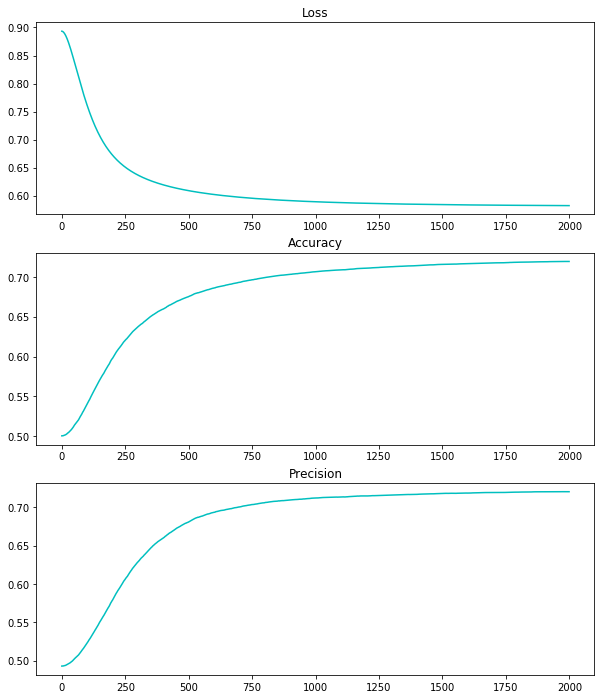

In [38]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=l, weight_decay=r, momentum=0.97)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 2000, R)
utils.plot_train_metrics(losses, train_acc, precision)

In [39]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.A), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.D), torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.09420701861381531
RMSE(D, D_true) =  0.13293157517910004


In [40]:
results = rank_similarities(A_true, R.detach().numpy(), sigmoid_irf.A.detach().numpy())
print(results['summary'])


    Summary of Ranking Evaluation: 
    Correlations with true rankings derived from A_true.
        Baseline: 
            Kendall:0.847 (p-value 0.0)
            Spearman: 0.966 (p-value 0.0) 
            
        Prediction:
            Kendall: 0.847 (p-value 0.0)
            Spearman: 0.97 (p-value 0.0)  
            
    Average difference: 0.002 (absolute diff., vs. the baseline) 
    


In [41]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.floored_exp_irf(_A[:, concepts[1]], _D[concepts], 10, guess_prob)
preds = (scores >= 0.5).float()
print('Oracle accuracy: ', torch.sum(R == preds).item() / (R.shape[0] * R.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Oracle accuracy:  0.79024
Inferred model accuracy:  0.7194100022315979
Inferred model precision:  0.7204891443252563


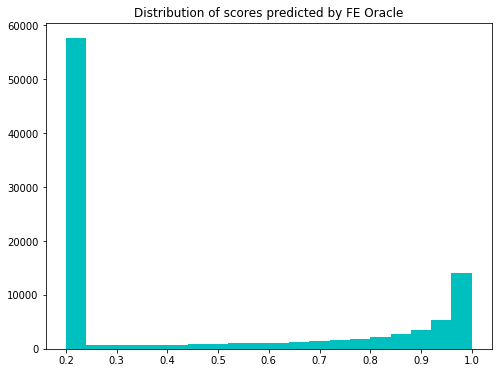

In [42]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by FE Oracle')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Dataset: FE Correl

In [43]:
R = torch.tensor(np.load('../datasets/floored_exp_correl.npy'), dtype=dtype)
A_true = np.load('../datasets/students_correl.npy')
D_true = np.load('../datasets/questions_correl.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]

In [44]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob, 10)
max_acc, best_params = utils.hyperparam_search(models.FE_Model, init_params, {'lr':(-6,-1), 'reg':(-5,-1)}, 10, 300, R)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.05662858823465574, reg=0.001966760839944308, momentum=0


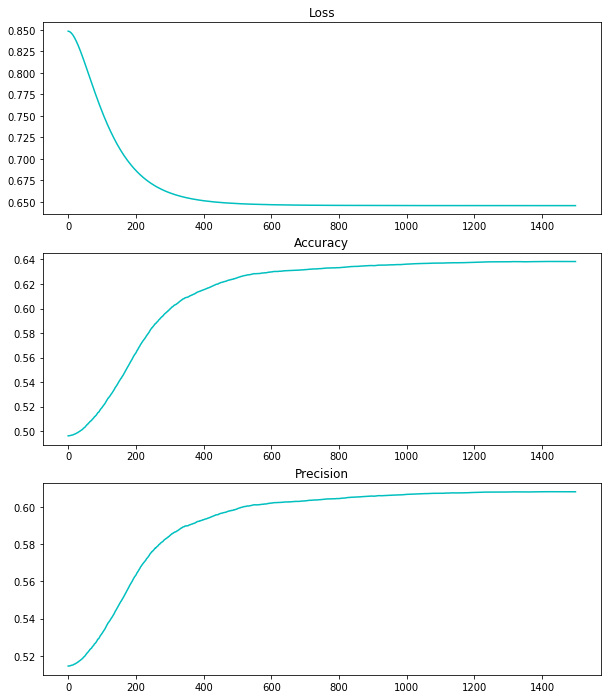

In [47]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=l, weight_decay=r, momentum=0.97)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 1500, R)
utils.plot_train_metrics(losses, train_acc, precision)

In [48]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.A), torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(utils.min_max_normalize(sigmoid_irf.D), torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.13055478036403656
RMSE(D, D_true) =  0.435777485370636


In [49]:
weights = np.array([0.2, 0.28, 0.17, 0.2, 0.15])
results = rank_similarities(A_true, R.detach().numpy(), sigmoid_irf.A.detach().numpy(), skill_weights=weights)
print(results['summary'])


    Summary of Ranking Evaluation: 
    Correlations with true rankings derived from A_true.
        Baseline: 
            Kendall:0.736 (p-value 0.0)
            Spearman: 0.902 (p-value 0.0) 
            
        Prediction:
            Kendall: 0.697 (p-value 0.0)
            Spearman: 0.877 (p-value 0.0)  
            
    Average difference: -0.032 (absolute diff., vs. the baseline) 
    


In [50]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.floored_exp_irf(_A[:, concepts[1]], _D[concepts], 10, guess_prob)
preds = (scores >= 0.5).float()
print('Oracle accuracy: ', torch.sum(R == preds).item() / (R.shape[0] * R.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Oracle accuracy:  0.80246
Inferred model accuracy:  0.6382799744606018
Inferred model precision:  0.6080928444862366


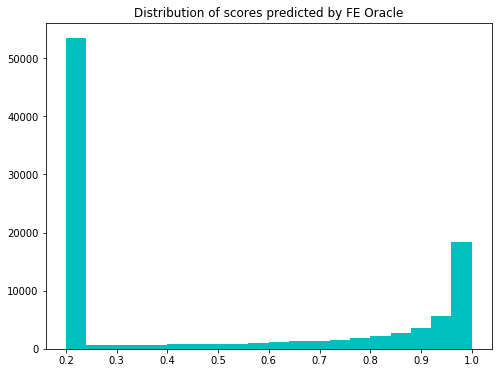

In [51]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by FE Oracle')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Dataset: Real

In [71]:
R = torch.tensor(np.genfromtxt('../datasets/real_data.csv', delimiter=','), dtype=dtype)
num_students = R.shape[0]
# We assume the real data set tests a single concept

train = R[:int(num_students*0.8)]
test = R[int(num_students*0.8):]
num_students, num_questions = train.shape
num_concepts = 1
concepts = (list(range(num_questions)), [0]*num_questions)

We first infer the difficulty matrix from the train set.

In [72]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob, 10)
max_acc, best_params = utils.hyperparam_search(models.FE_Model, init_params, {'lr':(-6,-1), 'reg':(-5,-1)}, 10, 300, train)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.02332883871089534, reg=0.04824914281180255, momentum=0


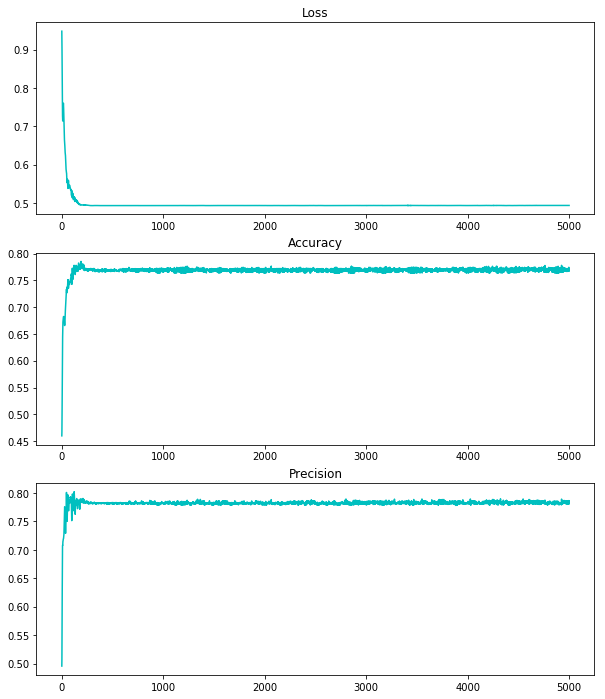

In [73]:
l, r, m = best_params
fe_irf = models.FE_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(fe_irf.parameters(), lr=l, weight_decay=r, momentum=0.97)
losses, train_acc, precision = utils.train(fe_irf, optim, 5000, train)
utils.plot_train_metrics(losses, train_acc, precision)

In [74]:
print(rank_similarities_real(train.numpy(), fe_irf.A.detach().numpy())['summary'])


    Summary of Ranking Evaluation:
    Correlations between R and A_pred.
    
        Baseline: 
            Kendall:0.863 (p-value 0.0)
            Spearman: 0.955 (p-value 0.0) 
            
        Average Correlation: 0.909
    


In [75]:
D = fe_irf.D

We now learn the abilities matrix of students in the test set from the first 8 questions of the test set.

In [76]:
test1 = test[:, :-1]
test2 = test[:, -1]
num_students, num_questions = test1.shape
num_concepts = 1
concepts = (list(range(num_questions)), [0]*num_questions)

In [77]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob)
max_acc, best_params = utils.hyperparam_search(models.FE_Model, init_params, {'lr':(-6,-1), 'reg':(-5,-1)}, 10, 300, test1)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

Best parameters: lr=0.07036426675556055, reg=0.028975337521324092, momentum=0


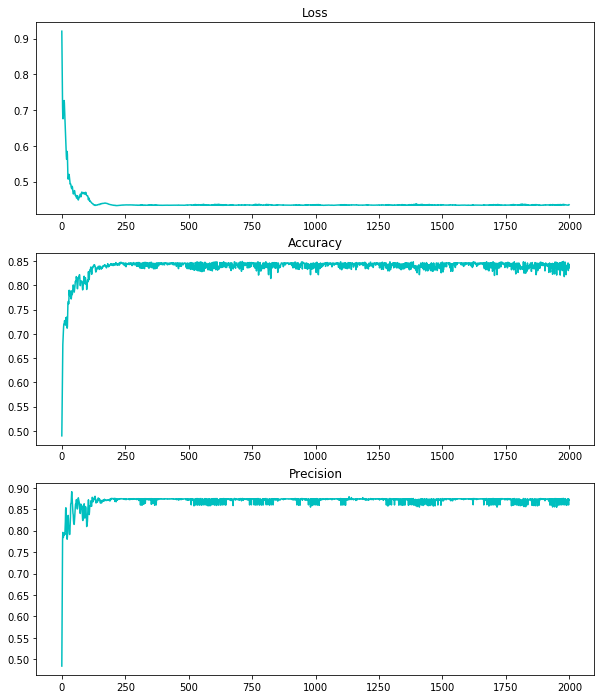

In [78]:
l, r, m = best_params
fe_irf = models.FE_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(fe_irf.parameters(), lr=l, weight_decay=r, momentum=0.97)
losses, train_acc, precision = utils.train(fe_irf, optim, 2000, test1)
utils.plot_train_metrics(losses, train_acc, precision)

In [79]:
A = fe_irf.A

probs = models.two_param_sigmoid_irf(A, D[-1], guess_prob)

preds = (probs.detach().numpy() >= 0.5).astype(int)

print('Test acc = {}'.format(np.mean((preds == test2.numpy()).astype(int))))

Test acc = 0.76875
